19/19 [==============================] - 0s 5ms/step - loss: 74.4296 - accuracy: 0.4726

Fold 1 - Test loss: 74.42957305908203, Test accuracy: 0.4726027250289917


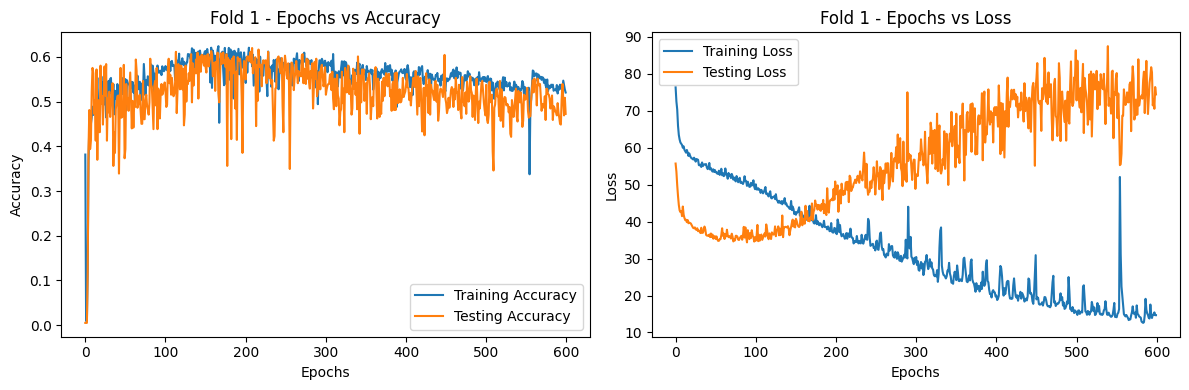

19/19 [==============================] - 1s 3ms/step

Fold 1 - Mean Squared Error: 74.42958480932963


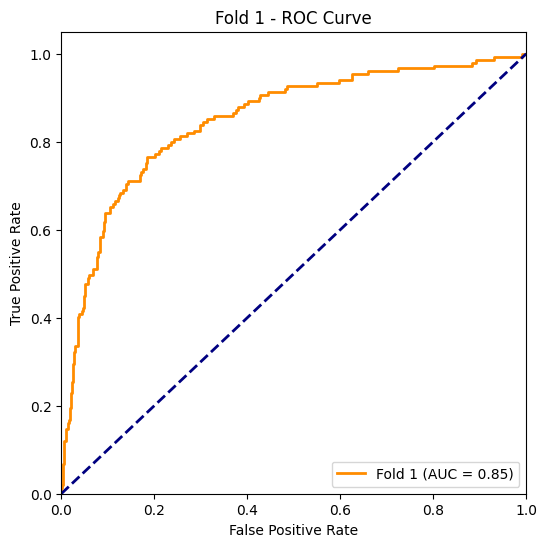

19/19 [==============================] - 0s 4ms/step - loss: 95.2405 - accuracy: 0.5034

Fold 2 - Test loss: 95.24053192138672, Test accuracy: 0.5034246444702148


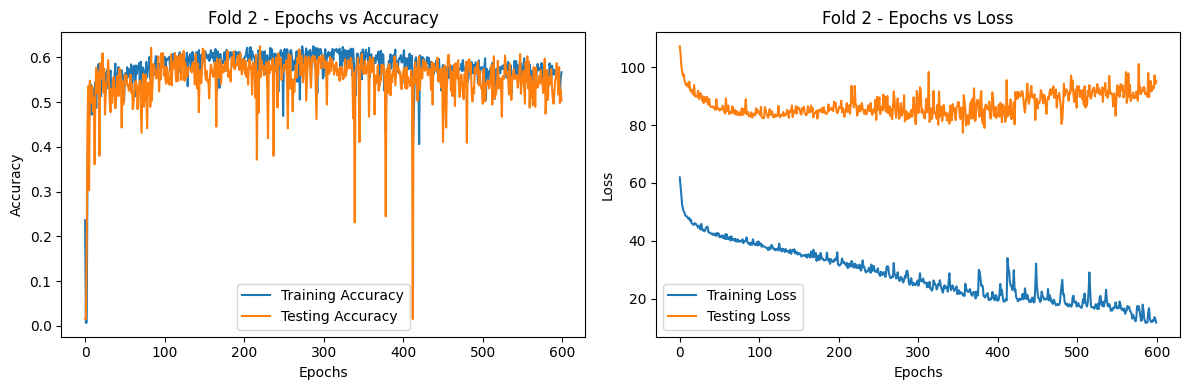

19/19 [==============================] - 1s 4ms/step

Fold 2 - Mean Squared Error: 95.24052209010263


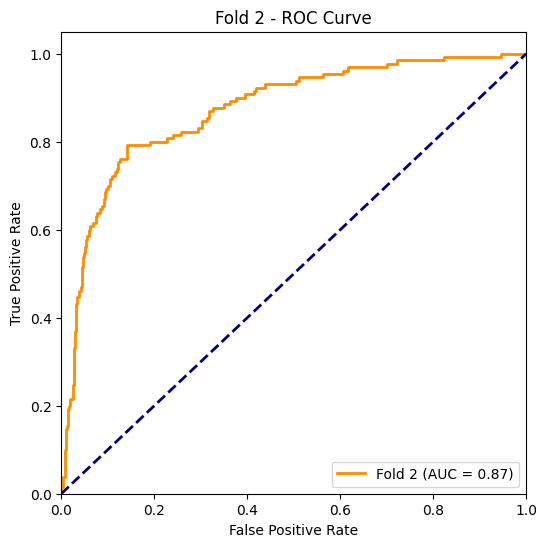

19/19 [==============================] - 0s 3ms/step - loss: 95.3647 - accuracy: 0.5342

Fold 3 - Test loss: 95.3647232055664, Test accuracy: 0.534246563911438


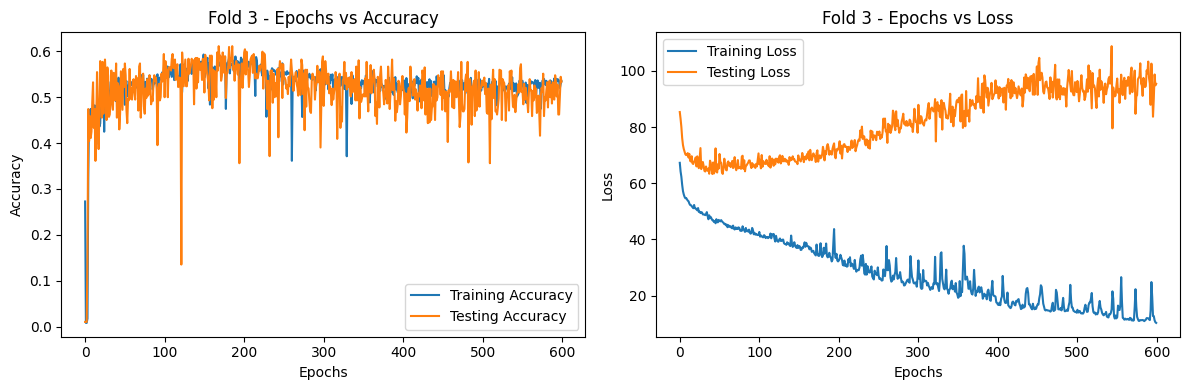

19/19 [==============================] - 1s 4ms/step

Fold 3 - Mean Squared Error: 95.3647313444823


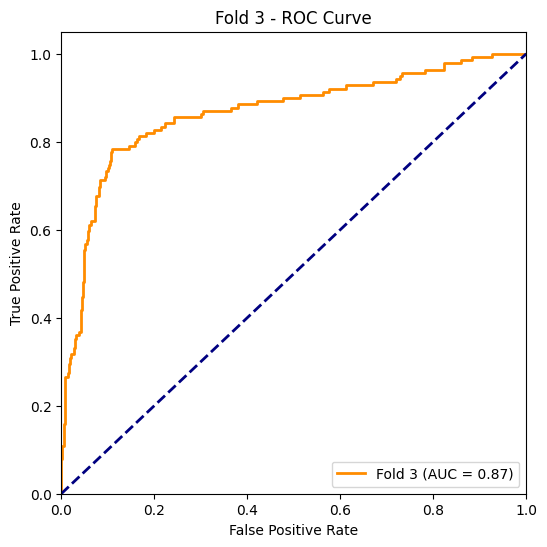

19/19 [==============================] - 0s 4ms/step - loss: 59.7831 - accuracy: 0.6387

Fold 4 - Test loss: 59.78314208984375, Test accuracy: 0.6386986374855042


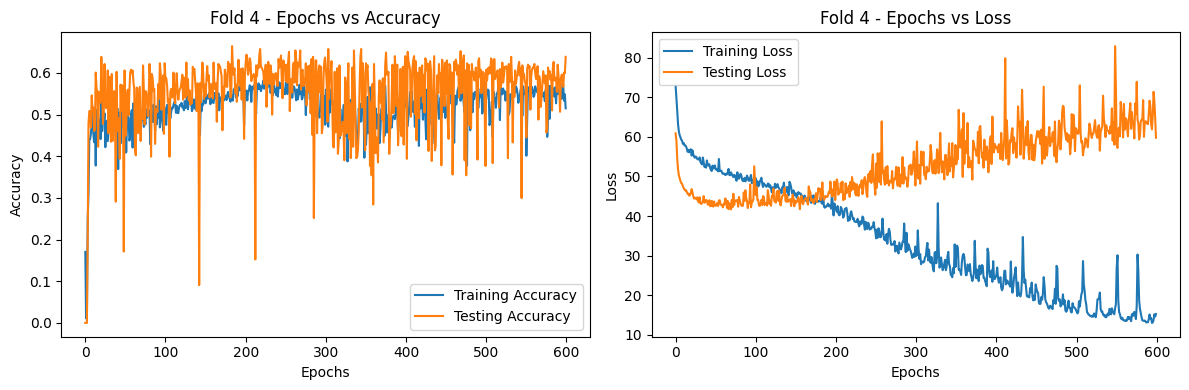

19/19 [==============================] - 1s 5ms/step

Fold 4 - Mean Squared Error: 59.783142992444354


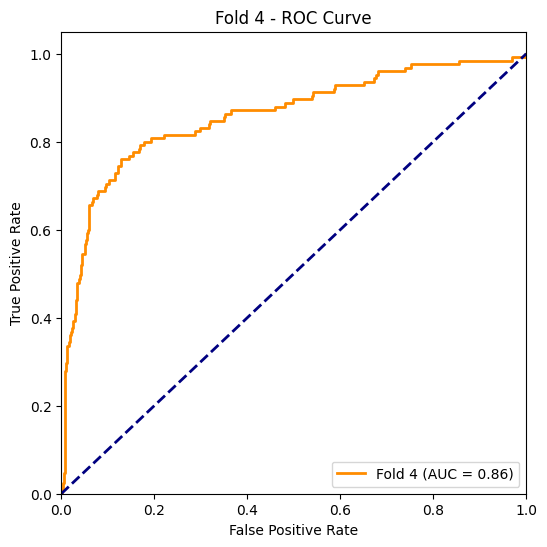

19/19 [==============================] - 0s 4ms/step - loss: 41.9953 - accuracy: 0.5986

Fold 5 - Test loss: 41.9952507019043, Test accuracy: 0.5986278057098389


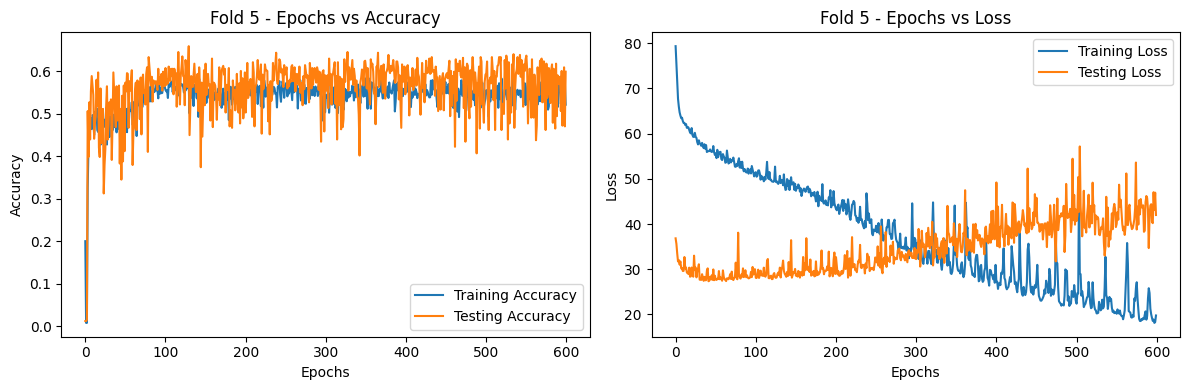

19/19 [==============================] - 1s 4ms/step

Fold 5 - Mean Squared Error: 41.995253310328884


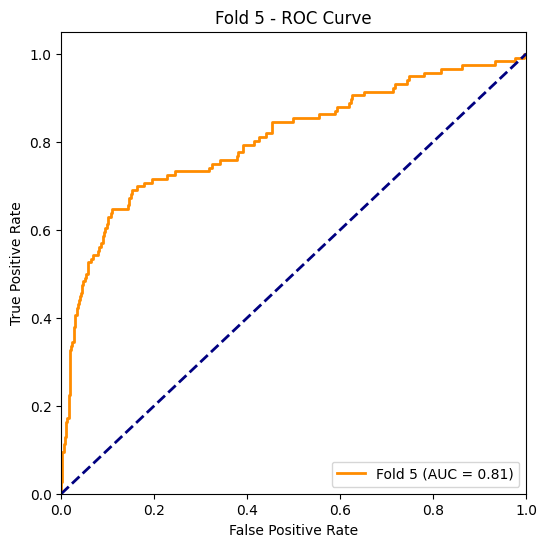

19/19 [==============================] - 0s 3ms/step


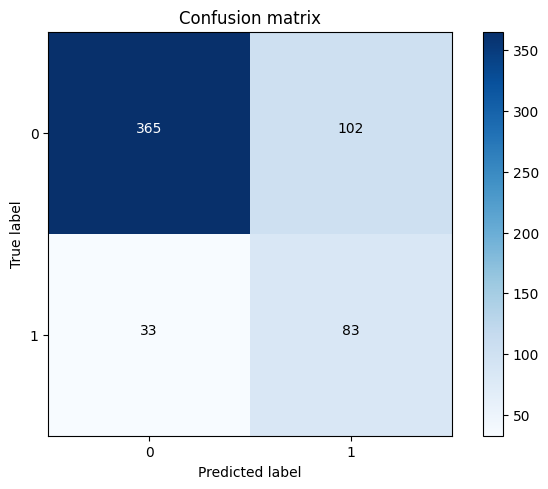

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error
import itertools
import matplotlib.pyplot as plt

# Load the dataset
raw_df = pd.read_csv('/content/drive/MyDrive/rain_data.csv')

# Create a time series dataset
X = raw_df[['Temperature', 'Pressure', 'Dew_Point', 'Humidity', 'Wind_Speed', 'Month', 'Date']]
y = raw_df['Precipitation']

# Convert the data into sequences
sequence_length = 3  # Adjust this value based on your data
X_sequence = [X[i:i+sequence_length].values for i in range(len(X) - sequence_length)]
y_sequence = y[sequence_length:].values

# Create an LSTM model
def create_model():
    model = keras.Sequential([
        keras.layers.LSTM(64, activation='sigmoid', input_shape=(sequence_length, X.shape[1]), return_sequences=True),
        keras.layers.LSTM(32, activation='sigmoid', return_sequences=True),
        keras.layers.LSTM(16, activation='sigmoid', return_sequences=True),
        keras.layers.LSTM(8, activation='tanh'),
        keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True)
epochs = 600
fold_number = 1

for train_index, test_index in kf.split(X_sequence):
    X_train, X_test = np.array(X_sequence)[train_index], np.array(X_sequence)[test_index]
    y_train, y_test = np.array(y_sequence)[train_index], np.array(y_sequence)[test_index]

    model = create_model()

    # Train the LSTM model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"\nFold {fold_number} - Test loss: {loss}, Test accuracy: {accuracy}")

    # Plot epochs vs accuracy for both training and testing
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
    plt.title(f'Fold {fold_number} - Epochs vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot epochs vs loss for both training and testing
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Testing Loss')
    plt.title(f'Fold {fold_number} - Epochs vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Make predictions for evaluation
    y_pred = model.predict(X_test)

    # Evaluate the model using Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print(f"\nFold {fold_number} - Mean Squared Error: {mse}")

    # Binarize y_test
    y_test_binary = (y_test > 0.5).astype(int)

    # Calculate fpr and tpr for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred)

    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Fold {fold_number} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Fold {fold_number} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    fold_number += 1

y_pred = model.predict(X_test)

# Convert y_test and y_pred to binary values (0 or 1)
y_test_binary = (y_test > 0.5).astype(int)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert y_test_binary and y_pred_binary to 1D arrays
y_test_binary = y_test_binary.ravel()
y_pred_binary = y_pred_binary.ravel()

# Get the unique classes in y_test_binary and y_pred_binary
classes = np.unique(np.concatenate((y_test_binary, y_pred_binary)))

# Calculate confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

# Use classes as tick locations and labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'  # Use 'd' for integer format
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

